# Exact Chemical Master Equation Solver

For finite state spaces, the Chemical Master Equation can be solved exactly via matrix exponentiation:

$$P(t) = e^{Qt} P(0)$$

where $Q$ is the generator (rate) matrix. This gives the exact probability distribution over states, which we can compare to stochastic simulations.

In [15]:
import jax
import jax.numpy as jnp
import jumpax as jx
import matplotlib.pyplot as plt
from matplotlib import cm

## Birth-Death Process

Consider a simple birth-death process with:

- Birth: $\emptyset \xrightarrow{\lambda} X$ with rate $\lambda$

- Death: $X \xrightarrow{\mu} \emptyset$ with rate $\mu \cdot n$

where $n$ is the current population.

In [16]:
lam, mu = 5.0, 0.5

# Reactants: birth needs nothing (0), death needs 1 particle
# Net change: birth +1, death -1
reactants = jnp.array([[0], [1]])
net_stoich = jnp.array([[1], [-1]])
rates = jnp.array([lam, mu])

problem = jx.MassActionJump(reactants, net_stoich, rates=rates)

## Build Generator Matrix

We truncate the state space to $n \in \{0, 1, ..., N_{max}\}$ and build the generator matrix.

In [17]:
max_counts = jnp.array([50])

Q, cme_state = jx.build_generator(problem, max_counts)

print(f"State space size: {Q.shape[0]}")
print(f"States shape: {cme_state.states.shape}")
print(f"Q matrix shape: {Q.shape}")

State space size: 51
States shape: (51, 1)
Q matrix shape: (51, 51)


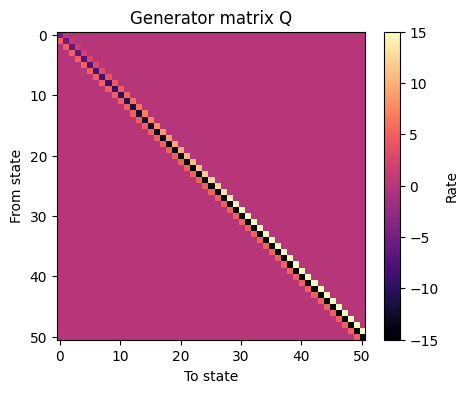

In [18]:
plt.figure(figsize=(5, 4))
plt.imshow(Q, cmap="magma", vmin=-15, vmax=15)
plt.colorbar(label="Rate")
plt.xlabel("To state")
plt.ylabel("From state")
plt.title("Generator matrix Q")
plt.show()

## Solve the CME

Starting from $n=0$, compute the probability distribution at various times.

In [19]:
# Initial distribution: start at n=0 with probability 1
p0 = jnp.zeros(Q.shape[0])
p0 = p0.at[0].set(1.0)

times = jnp.array([0.5, 1.0, 2.0, 5.0, 10.0])
distributions = jax.jit(jax.vmap(lambda t: jx.solve_cme(Q, p0, t)))(times)

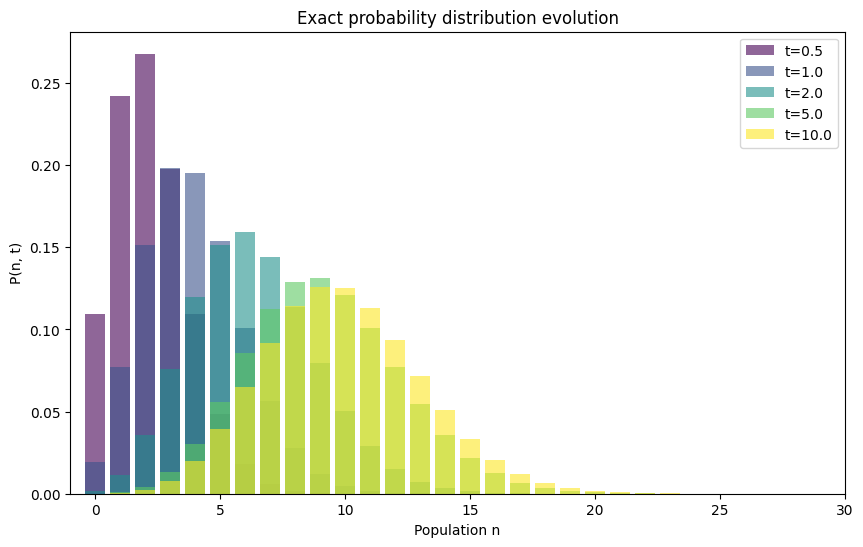

In [20]:
plt.figure(figsize=(10, 6))
colors = cm.viridis(jnp.linspace(0, 1, len(times)))

for i, (t, p) in enumerate(zip(times, distributions)):
    states = cme_state.states[:, 0]
    plt.bar(states, p, alpha=0.6, label=f"t={t:.1f}", color=colors[i], width=0.8)

plt.xlim(-1, 30)
plt.xlabel("Population n")
plt.ylabel("P(n, t)")
plt.title("Exact probability distribution evolution")
plt.legend()
plt.show()

## Compare to SSA Simulations

In [21]:
n_samples = 2000
t_final = 5.0


@jax.jit
@jax.vmap
def run_ssa(key):
    sol = jx.solve(
        problem,
        jx.SSA(),
        jx.Save(states=True),
        jnp.array([0]),
        t0=0.0,
        t1=t_final,
        args=None,
        key=key,
    )
    final_idx = sol.stats["num_steps"] - 1
    return sol.us[final_idx, 0]


key = jax.random.key(0)
final_states = run_ssa(jax.random.split(key, n_samples))

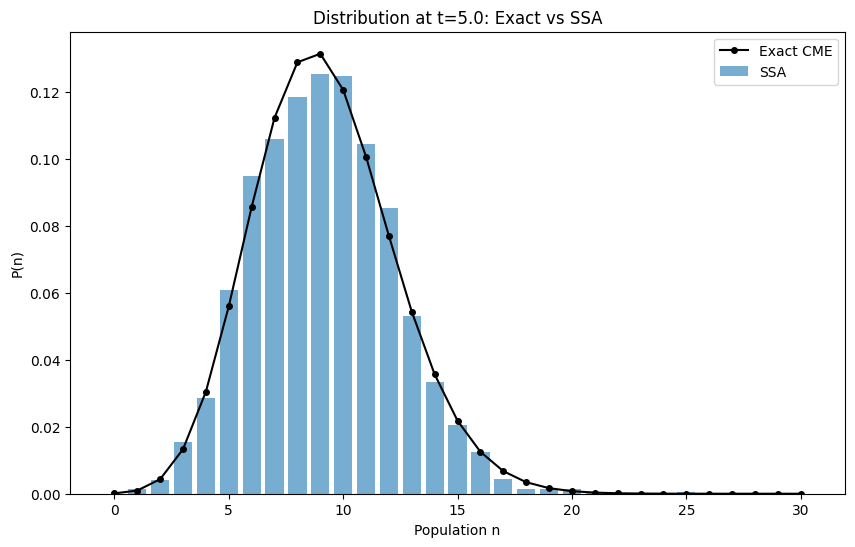

In [22]:
p_exact = jx.solve_cme(Q, p0, t_final)

max_n = 30
bins = jnp.arange(max_n + 2) - 0.5
hist, _ = jnp.histogram(final_states, bins=bins, density=True)

plt.figure(figsize=(10, 6))
plt.bar(jnp.arange(max_n + 1), hist, alpha=0.6, label="SSA", width=0.8)
plt.plot(
    jnp.arange(max_n + 1), p_exact[: max_n + 1], "ko-", label="Exact CME", markersize=4
)
plt.xlabel("Population n")
plt.ylabel("P(n)")
plt.title(f"Distribution at t={t_final}: Exact vs SSA")
plt.legend()
plt.show()

## Two-Species: Simple Gene Expression

(claude suggested this idea, so I apologize to any biologists if this is woefully incorrect)

Model with mRNA (M) and protein (P):

- Transcription: $\emptyset \xrightarrow{k_m} M$

- Translation: $M \xrightarrow{k_p} M + P$

- mRNA decay: $M \xrightarrow{\gamma_m} \emptyset$

- Protein decay: $P \xrightarrow{\gamma_p} \emptyset$

In [23]:
k_m, k_p = 2.0, 5.0  # transcription, translation rates
gamma_m, gamma_p = 1.0, 0.5  # decay rates

# Reactions:
#   1. transcription: 0 -> M
#   2. translation:   M -> M + P (M catalyzes P production)
#   3. mRNA decay:    M -> 0
#   4. protein decay: P -> 0

reactants_gene = jnp.array(
    [
        [0, 0],  # transcription: needs nothing
        [1, 0],  # translation: needs 1 M
        [1, 0],  # mRNA decay: needs 1 M
        [0, 1],  # protein decay: needs 1 P
    ]
)

net_stoich_gene = jnp.array(
    [
        [1, 0],  # transcription: +1 M
        [0, 1],  # translation: +1 P (M unchanged)
        [-1, 0],  # mRNA decay: -1 M
        [0, -1],  # protein decay: -1 P
    ]
)

rates_gene = jnp.array([k_m, k_p, gamma_m, gamma_p])

gene_problem = jx.MassActionJump(reactants_gene, net_stoich_gene, rates=rates_gene)

In [35]:
max_counts_gene = jnp.array([8, 40])
Q_gene, cme_gene = jx.build_generator(gene_problem, max_counts_gene)

print(
    f"State space size: {Q_gene.shape[0]} ({max_counts_gene[0]} x {max_counts_gene[1]})"
)

State space size: 369 (8 x 40)


In [36]:
# Initial distribution: M=0, P=0
p0_gene = jnp.zeros(Q_gene.shape[0])
p0_gene = p0_gene.at[0].set(1.0)

# Solve at steady state
t_ss = 20.0
p_ss = jax.jit(jx.solve_cme)(Q_gene, p0_gene, t_ss)

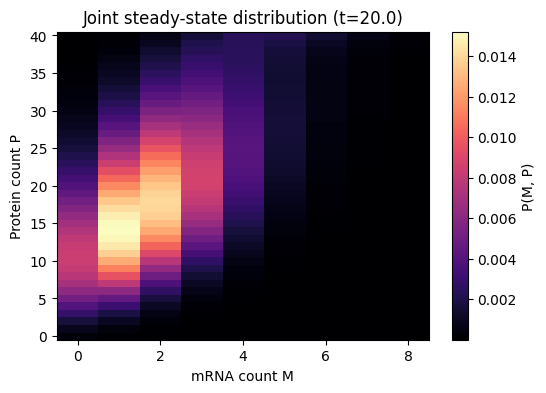

In [37]:
n_m = max_counts_gene[0] + 1
n_p = max_counts_gene[1] + 1
p_2d = p_ss.reshape(n_m, n_p)

plt.figure(figsize=(6, 4))
plt.imshow(p_2d.T, origin="lower", aspect="auto", cmap="magma")
plt.colorbar(label="P(M, P)")
plt.xlabel("mRNA count M")
plt.ylabel("Protein count P")
plt.title(f"Joint steady-state distribution (t={t_ss})")
plt.show()

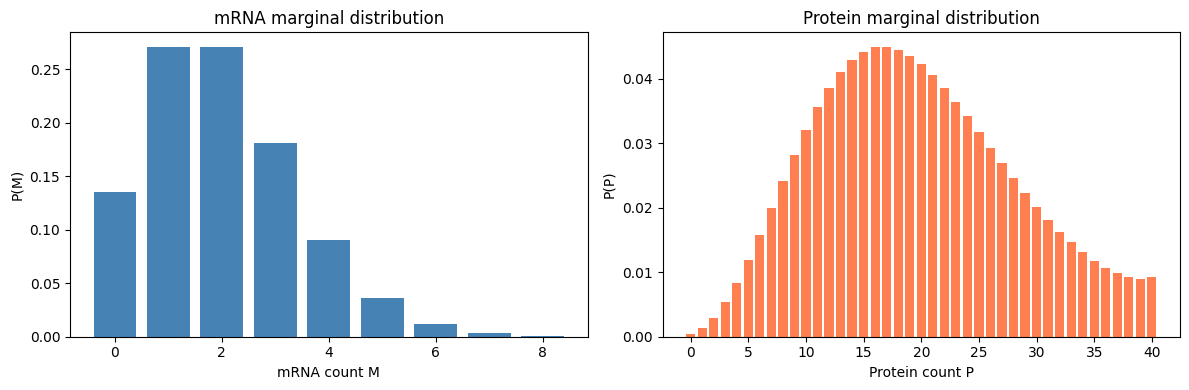

In [38]:
p_m = jx.marginal_distribution(p_ss, cme_gene, species=0)
p_p = jx.marginal_distribution(p_ss, cme_gene, species=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(jnp.arange(n_m), p_m, color="steelblue")
axes[0].set_xlabel("mRNA count M")
axes[0].set_ylabel("P(M)")
axes[0].set_title("mRNA marginal distribution")

axes[1].bar(jnp.arange(n_p), p_p, color="coral")
axes[1].set_xlabel("Protein count P")
axes[1].set_ylabel("P(P)")
axes[1].set_title("Protein marginal distribution")

plt.tight_layout()
plt.show()

## Time Evolution of Means

Track how expected counts evolve over time.

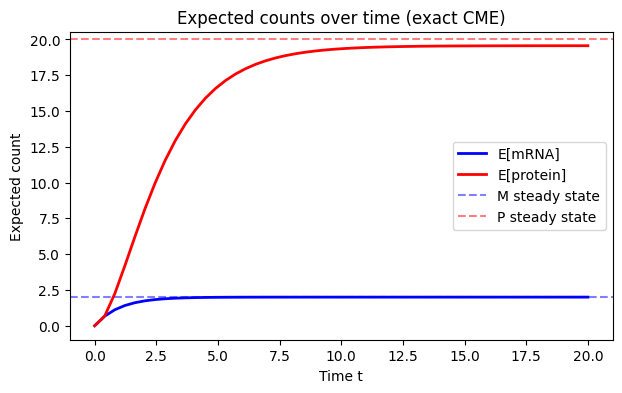

In [39]:
ts_gene = jnp.linspace(0, 20, 50)
ps_gene = jax.vmap(lambda t: jx.solve_cme(Q_gene, p0_gene, t))(ts_gene)


# Compute expected values E[M] and E[P] at each time
def expected_counts(p):
    return jnp.sum(p[:, None] * cme_gene.states, axis=0)


means = jax.jit(jax.vmap(expected_counts))(ps_gene)

plt.figure(figsize=(7, 4))
plt.plot(ts_gene, means[:, 0], "b-", linewidth=2, label="E[mRNA]")
plt.plot(ts_gene, means[:, 1], "r-", linewidth=2, label="E[protein]")

# Analytical steady states for comparison
m_ss = k_m / gamma_m
p_ss_analytical = k_m * k_p / (gamma_m * gamma_p)
plt.axhline(m_ss, color="b", linestyle="--", alpha=0.5, label="M steady state")
plt.axhline(
    p_ss_analytical, color="r", linestyle="--", alpha=0.5, label="P steady state"
)

plt.xlabel("Time t")
plt.ylabel("Expected count")
plt.title("Expected counts over time (exact CME)")
plt.legend()
plt.show()